# Adrien Le Louer - Data Challenge

## 0. Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import numpy as np
import re
import matplotlib.pyplot
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.data import load
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report

## 1. First look at the data and potential approaches  

The dataset is a collection of text queries from a financial institution's customers. Some queries contain numbers. Each entry consist of a short piece of text representing a customer query and a corresponding label indicating the category of the query. The categories are integer-encoded : each number represents an issue ( fees charged, balance discrepancies, etc ). 

In [3]:
train_df = pd.read_csv("complaints.csv")

In [3]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2169 entries, 0 to 2168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2169 non-null   object
 1   label   2169 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.0+ KB


,text,label
0,Why did I only receive a partial amount of wha...,3
1,my atm transaction was wrong,3
2,why did i only get 20.00,3
3,Why is my cash request and the amount I receiv...,3
4,"I tried to withdraw $100, all it gave me was $20.",3


Lets check the length of the queries, it is always useful to know this when we will select the way we vectorize, if we do topic modeling or not 

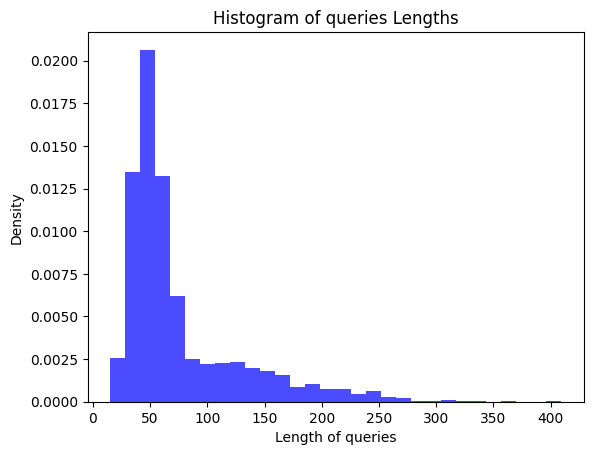

In [4]:
plt.hist(train_df['text'].apply(len), bins=30, density=True, alpha=0.7, color='blue')
plt.title('Histogram of queries Lengths')
plt.xlabel('Length of queries')
plt.ylabel('Density')
plt.show()


The labels are almost evenly distributed

In [5]:
train_df.groupby('label').count()

,text
label,
0,227
1,222
2,221
3,220
4,217
5,215
6,213
7,212
8,211


There are no NA values to process

In [6]:
train_df[train_df["text"].isna()].count()

text     0
label    0
dtype: int64

Now that we saw what the dataset looks like, different approaches could be tackled :

- `Machine Learning Classification` : Use of traditional machine learning algorithms like Naive bayes, Support Vector Machines, Random Forest Classifiers
    - `Pros` : Efficient with small datasets, interpretable, fast, can achieve good performance with thorough feature engineering

    - `Cons` : Need thorough and exhaustive feature engineering, less effective with high-dimensionality, no context

- `Deep Learning Classification` : Use of Neural Network architectures like Convolutional Neural Networks, Recurrent Neural Network . These methods can capture contextual information, possibly long term memory and perform well on large datasets
    - `Pros` : Automatic feature extraction, use of the context, scalability

    - `Cons` : Need a lot of data, computationally intensive, hard interpretability

- `Transfer Learning` : Use pre-trained language models like BERT or GPT, which can be fine-tuned on the dataset
    - `Pros` : Quick adaptation, reduced training time

    - `Cons` : Require lot of memory and processing power, can overfit

--> What approaches to do then ?
Because of the time constraint, I will go for `Machine Learning Classification` because it is much faster to implement and debug, moreover the dataset is not that big so I should get good results. If I still have time left, I will explore Deep Learning.

## 2. Machine Learning Classification : Implementation

### 2.1 Processing of the text feature

Before building any model, the first thing to do is always to process the text data. It will consists in : removing stop words, removing punctuation, transform the text query into tokens, lemmatize the tokens. It allows the model to be more robust to noise, learn faster and better and apply some kind of normalization to the text.

One thing to keep in mind is that sometimes, number appear. It would be then good to keep this information because some issues would more likely incite the customer to write an number in the query.

Also, in the sentence "Why did I only get 20$", we need to keep the only because it carries important meaning. So we need to be careful the way we remove stop words.

In [7]:
stop = set(stopwords.words("english"))
punctuation = set(string.punctuation)
lemma = WordNetLemmatizer()

In [8]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADV
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('V'):
        return wordnet.VERB
    else:
        return wordnet.NOUN

def process_sent(sentence):
    sentence = sentence.strip().lower().split()
    words = [re.sub(r'\d+(\.\d+)?', 'number', word) for word in sentence] # Replace numbers with NUMBER token
    words = [word.strip(string.punctuation) for word in words]

    pos_tagged = pos_tag(words)

    cleaned_sent = [
        lemma.lemmatize(word, get_wordnet_pos(pos)) for (word, pos) in pos_tagged \
                    if  word.isalpha() and not ( word in stop and get_wordnet_pos(pos) not in [wordnet.ADV, wordnet.ADV] )  # Keep adverbs, adjectives
    ]

    return " ".join(word for word in cleaned_sent)

In [9]:
train_df['text_processed'] = train_df['text'].apply(process_sent)
train_df.head()

,text,label,text_processed
0,Why did I only receive a partial amount of wha...,3,only receive partial amount try withdraw
1,my atm transaction was wrong,3,atm transaction wrong
2,why did i only get 20.00,3,only get number
3,Why is my cash request and the amount I receiv...,3,cash request amount receive different
4,"I tried to withdraw $100, all it gave me was $20.",3,try withdraw number give number


### 2.2 Vectorizing the text data

Now that the text data is processed, we need to find a way to vectorize it so that the models can train on this data. We can vectorize it in two ways :
- Compute the matrix containing the number of occurences of the n-grams with n pre-selected
- Compute the TF-IDF matrix

We classify customer queries which are about only one topic, so TF-IDF should be better to emphasize words containing a lot of information

In [12]:
tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1, 3))
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df['text_processed'])
print("TF-IDF Shape :", tfidf_matrix.shape)


TF-IDF Shape : (2169, 1974)


We could do some topic modeling like NMF, LSA or LDA and then use the resulting matrix for training the model but here, the queries are really short and each of them mostly talk about only one topic, so I do not think it is necessary

### 2.3 Defining models

We will pick Naive Bayes, Random Forest and SVM models to classify the text queries because they are the most classic in this context

In [13]:
svm_model = SVC(kernel='linear', random_state=1)
svm_param_grid = {
    'C':[0.1, 1, 10, 50],
    'kernel':['linear', 'rbf'],
    'gamma':[0.001, 0.01, 0.1]
}
rf_model = RandomForestClassifier(random_state=1)
rf_param_grid = {
    'n_estimators':[100, 200, 400],
    'max_features':["sqrt", "log2"],
    'max_depth':[20, 40],
    'min_samples_split':[2, 5]
}
nb_model = MultinomialNB()
nb_param_grid = {
    'alpha':[0.1, 0.5, 1, 10],
    'fit_prior': [True, False]
}

## 3. Training and evaluation

We will perform `cross-validation` to select the model and use `accuracy`, and the `confusion_matrix` to measure performances. I would have use also recall, F1-score and precision but I lack time

---- SVM Model ----
Label 0, Numer of false predictions : 1
Label 1, Numer of false predictions : 1
Label 2, Numer of false predictions : 2
Label 3, Numer of false predictions : 3
Label 4, Numer of false predictions : 5
Label 5, Numer of false predictions : 1
Label 6, Numer of false predictions : 2
Label 7, Numer of false predictions : 3
Label 8, Numer of false predictions : 4
Label 9, Numer of false predictions : 2


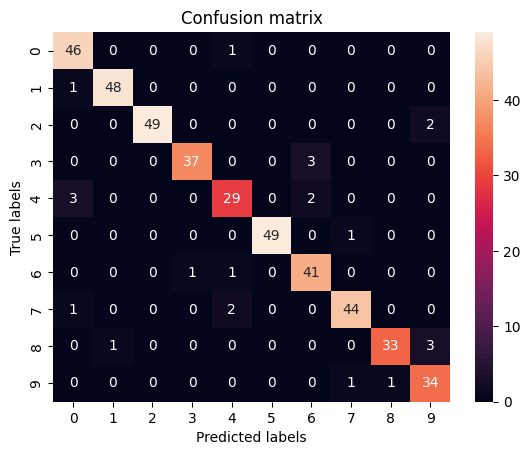

SVM Model Accuracy :  0.9447004608294931 

---- Random Forest Model ----
Label 0, Numer of false predictions : 5
Label 1, Numer of false predictions : 4
Label 2, Numer of false predictions : 1
Label 3, Numer of false predictions : 3
Label 4, Numer of false predictions : 5
Label 5, Numer of false predictions : 2
Label 6, Numer of false predictions : 2
Label 7, Numer of false predictions : 3
Label 8, Numer of false predictions : 3
Label 9, Numer of false predictions : 2


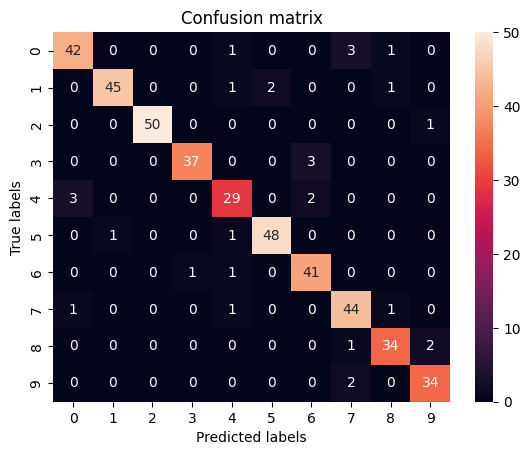

Random Forest Model Accuracy :  0.9308755760368663
---- Naive Bayes Model ----
Label 0, Numer of false predictions : 5
Label 1, Numer of false predictions : 3
Label 2, Numer of false predictions : 3
Label 3, Numer of false predictions : 3
Label 4, Numer of false predictions : 5
Label 5, Numer of false predictions : 1
Label 6, Numer of false predictions : 3
Label 7, Numer of false predictions : 4
Label 8, Numer of false predictions : 4
Label 9, Numer of false predictions : 3


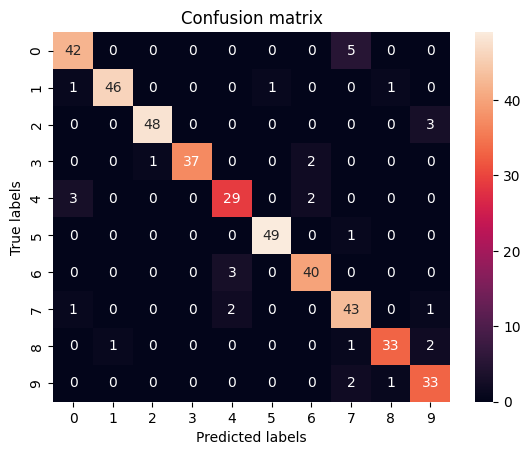

Naive Bayes Model Accuracy :  0.9216589861751152 



In [14]:

def train_and_evaluate(model, param_grid, X, y, cv):
    X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, train_df['label'], test_size=0.2, random_state=1)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    test_accuracy = best_model.score(X_test, y_test)

    y_pred = best_model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)

    for i, row in enumerate(conf_matrix):
        false_predictions = sum(row) - row[i]
        print(f"Label {i}, Numer of false predictions : {false_predictions}")
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()

    return test_accuracy

X = tfidf_matrix
y = train_df['label']
print("---- SVM Model ----")
print("SVM Model Accuracy : ", train_and_evaluate(svm_model, svm_param_grid, X, y, cv=5), "\n")
print("---- Random Forest Model ----")
print("Random Forest Model Accuracy : ", train_and_evaluate(rf_model, rf_param_grid, X, y, cv=5))
print("---- Naive Bayes Model ----")
print("Naive Bayes Model Accuracy : ", train_and_evaluate(nb_model, nb_param_grid, X, y, cv=5), "\n")



The accuracies are the following : 
- SVM Model Accuracy :  0.94
- Random Forest Accuracy : 0.93
- Naive Bayes Accuracy : 0.92

## 4. Results discussion and recommendations

In terms of `accuracy, the best model is the SVM` one. In terms of the `number of falsely predicted label, SVM is also the best` with only 24 falsely predicted label in total. 

My `recommendation` for the business would be to `pick the SVM` model, `except` if, the business does not want a category to be falsely predicted because a false prediction would be really bad money-wise, time-wise or whatever reason. Then, I would advise to pick the model that have the lowest number of false predictions in the critical category or categories.

I would also recommend to further develop the model as 94% accuracy is not optimal and a much better accuracy could be achieved ( at least 97-98% fore sure ).


## 5. Improvements

Several improvements could be made :

- Collect more data, it never hurts

- Try different text processing techniques. I transformed all the numbers into a single token but maybe the amount can help categorize the text query. Also, I lemmatized the text but I could also stem it. I could also have done Named Entity Recognition to help the model understand the meaning

- Use a different vectorization. I used TF-IDF but maybe just using the number of occurences would have been better

- Use topic modeling. I did not do it but maybe some queries spoke about several topics that could lead to the right label

- Further tune the hyperparameters could have greatly improve the models performances

- Try ensemble methods ,like boosting, which often yield good results

- Do word embedding to vectorize the text and then train the model on it

- Explore Deep Learning and Transfer Learning